In [1]:
import cv2
import json
import numpy as np
from torchvision import models, transforms
import torch
from PIL import Image
from sklearn.svm import SVC
import joblib
import os

In [2]:
# 设置输入输出
target = 2

if target == 1:
    data_name = '0618'
elif target == 2:
    data_name = '0854'
elif target == 3:
    data_name = '1066'

input_path = f'./input_data/{data_name}.png'
annotations_pos_file = f'./Label_img/annotation_{data_name}_1.json'
annotations_neg_file = f'./Label_img/annotation_{data_name}_-1.json'

In [3]:
# 检查CUDA是否可用并设置设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 加载预训练的ResNet18模型，去掉最后的全连接层用于特征提取
model = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model = model.to(device)  # 移动模型到GPU
model.eval()

# 定义图片的转换操作
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 读取标注数据
with open(annotations_pos_file, 'r') as f:
    annotations_pos = json.load(f)
with open(annotations_neg_file, 'r') as f:
    annotations_neg = json.load(f)

# 提取特征并保存
features = []
labels = []

# 处理正样本
for annotation in annotations_pos['annotations']:
    label = annotation['label']
    vertices = np.array(annotation['vertices'], dtype=np.int32)
    # 读取图片并根据多边形顶点裁剪区域
    image = cv2.imread(input_path)
    if image is None:
        print(f"Image not found: {input_path}")
        continue
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [vertices], 255)
    road_area = cv2.bitwise_and(image, image, mask=mask)

    # 将裁剪的区域转换为模型输入所需的格式
    road_area = cv2.cvtColor(road_area, cv2.COLOR_BGR2RGB)
    road_area = Image.fromarray(road_area)
    road_area = transform(road_area)
    road_area = road_area.unsqueeze(0).to(device)

    # 提取特征
    with torch.no_grad():
        feature = model(road_area)
    
    features.append(feature.squeeze().cpu().numpy())
    labels.append(label)

# 处理负样本
for annotation in annotations_neg['annotations']:
    label = annotation['label']
    vertices = np.array(annotation['vertices'], dtype=np.int32)
    # 读取图片并根据多边形顶点裁剪区域
    image = cv2.imread(input_path)
    if image is None:
        print(f"Image not found: {input_path}")
        continue
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [vertices], 255)
    road_area = cv2.bitwise_and(image, image, mask=mask)

    # 将裁剪的区域转换为模型输入所需的格式
    road_area = cv2.cvtColor(road_area, cv2.COLOR_BGR2RGB)
    road_area = Image.fromarray(road_area)
    road_area = transform(road_area)
    road_area = road_area.unsqueeze(0).to(device)

    # 提取特征
    with torch.no_grad():
        feature = model(road_area)
    
    features.append(feature.squeeze().cpu().numpy())
    labels.append(label)   

Using device: cuda:0


/home/crisi/miniconda3/envs/d2l/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/crisi/miniconda3/envs/d2l/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
type(features)
print(labels)

[1, -1]


In [9]:
from sklearn import svm

# 训练SVM模型
svm_model = svm.SVC(kernel='rbf', random_state=42)
svm_model.fit(features, labels)

# 保存SVM模型
joblib.dump(svm_model, './model/svm_model_DL.pkl')

print(len(features))
print(len(labels))

2
2


/home/crisi/miniconda3/envs/d2l/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/crisi/miniconda3/envs/d2l/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


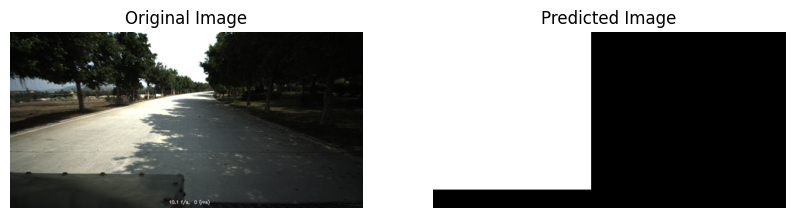

Predicted image saved to ./result_new/pred_0854_linear_DL.jpg


In [10]:
import cv2
import numpy as np
from torchvision import models, transforms
import torch
from joblib import load

# 加载预训练的ResNet18模型，去掉最后的全连接层用于特征提取
model = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model.eval()

# 检查CUDA是否可用并设置设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# 定义图片的转换操作
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_image(image, model, transform, device):
    h, w, _ = image.shape
    features = []

    # 定义小块的大小和步长
    patch_size = 224
    stride = patch_size - 10  # 10 pixels overlap

    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            # 裁剪小块
            patch = image[i:i+patch_size, j:j+patch_size]
            
            # 将小块转换为模型输入所需的格式
            patch = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
            patch = Image.fromarray(patch)
            patch = transform(patch)
            patch = patch.unsqueeze(0).to(device)

            # 提取特征
            with torch.no_grad():
                patch_feature = model(patch)
            
            # 将特征添加到列表中
            features.append(patch_feature.squeeze().cpu().numpy())

    return np.array(features)

# 加载模型
model_path = './model/svm_model_DL.pkl'
clf = load(model_path)

# 加载新的图片
input_path = './input_data/0854.png'  # 请确保这是正确的路径
new_image = cv2.imread(input_path)

# 将图片数据转换为模型可以处理的格式
features = preprocess_image(new_image, model, transform, device)

# 使用模型进行预测
predictions = clf.predict(features)

# 将预测结果应用到图片上
original_image = new_image
height, width, _ = original_image.shape
predicted_image = np.zeros_like(original_image)

# 定义小块的大小和步长
patch_size = 224
stride = patch_size - 10  # 10 pixels overlap

for i in range(0, height - patch_size + 1, stride):
    for j in range(0, width - patch_size + 1, stride):
        index = (i // stride) * ((width - patch_size + 1) // stride) + (j // stride)
        if predictions[index] == 1:
            predicted_image[i:i+patch_size, j:j+patch_size] = (255, 255, 255)

# 显示原始图片
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# 显示预测后的图片
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB))
plt.title('Predicted Image')
plt.axis('off')

# 显示图像
plt.show()

# 保存预测后的图片
new_image_name = os.path.splitext(os.path.basename(input_path))[0]
save_path = f'./result_new/pred_{new_image_name}_linear_DL.jpg'
cv2.imwrite(save_path, predicted_image)
print(f'Predicted image saved to {save_path}')